# Inteligencia Computacional

### Máster Universitario en Ingeniería Informática


# Entregable 1

En esta práctica implementaremos una búsqueda no clásica para segmentar los objetos de una imagen.


In [2]:
 #Imports
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from __future__ import division # Para obtener floats de las divisiones
import random
from time import time

In [2]:
# Leer la imagen
imagen = io.imread('caballos.jpg')
print imagen.shape

(321L, 481L, 3L)


umbral inicial:
[[  16.  190.  250.]]
La varianza máxima es:
[ 76032.87135396]
La varianza máxima es:
[ 76032.87135396]
Correspondiente al umbral: 
[ 16 180 250]
En un tiempo de ejecución:
30.1289999485


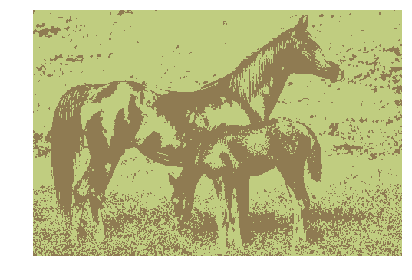

In [8]:
# BÚSQUEDA
imagen = io.imread('caballos.jpg')

# Parámetros de la búsqueda
n_vecinos = 3
prob = 0.2 # Probabilidad con la que empezaremos cogiendo al mejor vecino
to = 40 # Temperatura: la iniciamos a 40 iteraciones
temperatura = 40 #Iniciamos la temperatura
n_clases = 2
n_umbrales = n_clases-1

# Iniciamos un umbral o umbrales aleatorios o a un umbral resultado de anteriores búsquedas
umbrales_iniciales = np.zeros((n_umbrales,3))
for i in range(0,n_umbrales):
    umbrales_iniciales[i] = [random.randint(0,255) for _ in range(3)] # Revisar si 255 o hasta 254
# Mejor umbral hasta el momento
#umbrales_iniciales[0] = [202,159,73]
print 'umbral inicial:'
print umbrales_iniciales

# Calculamos la varianza del umbral inicial
[varianza_max, imagen_clases_max, media_max] = calcularVarianza(imagen, umbrales_iniciales, n_clases, n_umbrales)

# Iniciamos la búsqueda
umbral_max = umbrales_iniciales.copy()
umbral = umbrales_iniciales.copy()
varianza = np.zeros((n_vecinos,1))
vecinos = np.zeros((n_vecinos,3))
imagen_clases = np.zeros((imagen.shape[0], imagen.shape[1], n_vecinos))
media = np.zeros((n_clases,3,n_vecinos))
tiempo_inicial = time() 
iters_repes = 0 # Número de iteraciones sin mejorar la varianza
while temperatura > 0:
    
    # Generamos vecinos para cada conjunto de umbrales, conforme la temperatura disminuye, también lo hace la variación de los vecinos
    vecinos = generarVecinos(umbral, n_vecinos, to, temperatura)

    # Calculamos varianza vecinos
    for i in range(0,n_vecinos):
        [varianza[i], imagen_clases[:,:,i], media[:,:,i]] = calcularVarianza(imagen, [vecinos[i]], n_clases, n_umbrales)

    # Escogemos el mejor vecino con una probabilidad decreciente según el número de iteraciones
    pos_umbral_actual = elegirVecino(varianza, temperatura, to, n_vecinos)

    # Lo almacenamos si mejora la varianza
    if varianza[pos_umbral_actual] > varianza_max:
        varianza_max = varianza[pos_umbral_actual].copy()
        umbral_max = vecinos[pos_umbral_actual].copy()
        imagen_clases_max = imagen_clases[:,:,pos_umbral_actual].copy()
        media_max = media[:,:,pos_umbral_actual].copy()
        iters_repes = 0
        print 'La varianza máxima es:'
        print varianza_max
        
    # Continuamos la búsqueda en el siguiente 'nivel'
    umbral_actual = vecinos[pos_umbral_actual]
    temperatura -= 1
    iters_repes += 1
    # Si llevamos varias iteraciones sin encontrar mejores vecinos, avanzamos la salida del algoritmo
    # Además de aumentar la probabilidad de coger vecinos peores
    if iters_repes > 6: 
        temperatura -= 5

tiempo_final= time() 
print 'La varianza máxima es:'
print varianza_max
print 'Correspondiente al umbral: '
print umbral_max
print 'En un tiempo de ejecución:'
print tiempo_final - tiempo_inicial
# Representar la imagen segmentada
imagen_segmentada_colores = crearImagenSegmentada(imagen_clases_max, media_max, n_clases)
imprimirImagen(imagen_segmentada_colores)

In [3]:
# FUNCIONES AUXILIARES PARA EL CALCULO DE LA VARIANZA

def esMayor(umbral1, umbral2):
    # Devuelve 0 si el umbral1<umbral2, sino 1
    if ((umbral2[0]-umbral1[0]) + (umbral2[1]-umbral1[1]) + (umbral2[2]-umbral1[2])) < 0:
        return 1
    else: 
        return 0
    
def ordenamientoBurbuja(umbrales):
    for numPasada in range(len(umbrales)-1,0,-1):
        for i in range(numPasada):
            if esMayor(umbrales[i], umbrales[i+1]) == 1:
                temp = umbrales[i].copy()
                umbrales[i] = umbrales[i+1]
                umbrales[i+1] = temp
    return umbrales

def posicionPixel(pixel, umbrales):
    # Devuelve 0 si el pixel<umbral1, 1 si el umbral1<pixel<umbral2 ...
    for i in range(0, len(umbrales)):
        if esMayor(pixel,umbrales[i]) == 0:    
            return i
    return i+1

def crearImagenSegmentada(imagen, media, n_clases):
    imagen_def = np.zeros((imagen.shape[0],imagen.shape[1],3))
    for i in range(0,n_clases):
        imagen_def[imagen == i,:] = media[i]
    return imagen_def

def imprimirImagen(imagen):
    #Imprimimos y guardamos la imagen
    c=np.uint8(imagen)
    io.imshow(c)
    plt.axis("off")
    plt.show()
    io.imsave('miPiedraGuardado.png',c)

In [4]:
# FUNCIONES AUXILIARES DE LA BÚSQUEDA

def calcularVarianza(imagen, umbrales, n_clases, n_umbrales):
    umbral = ordenamientoBurbuja(umbrales)
    # CADA CLASE UNA FILA, LOS COLORES SON LAS COLUMNAS RED = 0, GREEN = 1, BLUE = 2
    contador = np.zeros((n_clases,1)) # numero de elementos de cada clase
    valor = np.zeros((n_clases,3)) # Suma pixeles de cada clase, por colores
    imagen_clases = np.zeros((imagen.shape[0],imagen.shape[1]))
    for i in range(0,imagen.shape[0]):#recorremos por filas
        for j in range(0,imagen.shape[1]):#recorremos por columnas
            clase = posicionPixel(imagen[i,j,:],umbral)
            imagen_clases[i,j] = clase
            contador[clase] += 1
            valor[clase] += imagen[i,j,:]
    media = valor / contador
    media[np.isnan(media)]=0 # Tratamos las divisiones entre cero
    mediaTotal = sum(media) / sum(contador)
    mediaTotal[np.isnan(mediaTotal)]=0 # Tratamos las divisiones entre cero
    prob = contador / sum(contador)
    varianza = sum(sum( (media - mediaTotal)**2 * prob ))
    return varianza, imagen_clases, media

def generarVecinos(umbrales, n_vecinos, to, temperatura):
    vecinos = np.zeros((n_vecinos, 3))
    # random.randrange(-1,2,2) genera el signo hacia el que modificamos el umbral aleatoriamente
    vecinos[0] = umbrales + (temperatura * 10 / to * random.randrange(-1,2,2), 0, 0)
    vecinos[1] = umbrales + (0,temperatura * 10 / to * random.randrange(-1,2,2), 0)
    vecinos[2] = umbrales + (0,0,temperatura * 10 / to * random.randrange(-1,2,2))
    vecinos[vecinos[:]<0] = 0
    return vecinos.astype(int)

def elegirVecino(varianza,  temperatura, to, n_vecinos):
    probabilidad =  temperatura / to
    rand = random.random()
    if rand < probabilidad: # Escogemos el mejor con una probabilidad que depende de la temperatura
        pos_max = 0
        val_max = varianza[0]
        for i in range(0,n_vecinos):
            if varianza[i] > val_max:
                pos_max = i
                val_max = varianza[i]
        return pos_max
    else:
        return random.randrange(0, n_umbrales)